Date: 04/13/2025

Author: Nasheed Jafri

Purpose: Modeling risk of Alzheimer's as probabilities instead of raw classification

# Introduction

In this notebook, we move beyond predictive modeling and turn our attention to understanding patterns and relationships within the data through inferential analysis. Specifically, we explore how the presence or absence of certain clinical and behavioral features affects the likelihood of an Alzheimer's diagnosis. The main goal would be early detection, so we only consider the subset of patients who exhibit no memory complaints.

Rather than training a model, our goal here is to derive interpretable, data-driven insights by computing conditional probabilities — such as:

- What is the probability of having Alzheimer’s, given that a patient exhibits behavioral problems?
- How does the risk change if a patient reports low MMSE performance?

This analysis allows us to:

- Quantify the individual contribution of key symptoms to Alzheimer’s risk,
- Gain transparency into the dataset beyond black-box models,
- Support hypothesis generation and guide clinical focus areas.

By grounding our findings in conditional probability and visual inspection, we aim to enhance interpretability and foster more informed, feature-specific reasoning in the context of Alzheimer’s disease.

# Inferential Analysis for patients with no memory complaints

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

In [5]:
df = pd.read_csv("/Users/nasheedjafri/Downloads/data/kaggle_train.csv")
df = df.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df = df.loc[df.MemoryComplaints == 0]
df_train, df_test = train_test_split(df, random_state= 123 , shuffle= True,
                                     test_size=0.2, stratify=df['Diagnosis'])

In [7]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


In [9]:
model_tuned_params = {
    'n_estimators': 342,
    'learning_rate': 0.2936557853809352,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 3,
    'subsample': 0.9505333790576483,
    'colsample_bytree': 0.6024713590870578,
    'reg_alpha': 0.22059934204998982,
    'reg_lambda': 0.8737784998045829,
    'scale_pos_weight': 1,
    'eval_metric': 'error'
}

model_tuned_ = XGBClassifier(**model_tuned_params, random_state=123)
model_tuned_.fit(df_train[all_features[:-1]], df_train.Diagnosis)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6024713590870578, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, feature_weights=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2936557853809352,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=342, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
# Isotonic calibration pipeline
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_tuned_, method='isotonic', cv=5)
calibrated_model_isotonic.fit(df_train[all_features[:-1]], df_train.Diagnosis)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.6024713590870578,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='error',
                                               feature_types=None,
                                               feature_weights=None, gamma=3,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.2936557853809352,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=2, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=342, n_jobs=None,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

In [13]:
# Predict calibrated probabilities on the test set
calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk'] = calibrated_probs_isotonic
df_test[['Diagnosis', 'alzheimers_risk']].head()

,Diagnosis,alzheimers_risk
1684,1,0.027583
1323,1,0.806522
157,0,0.032324
863,1,0.766112
975,1,0.961542


In [15]:
def assign_risk_group(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

In [17]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk', 'risk_group']].head()

,Diagnosis,alzheimers_risk,risk_group
1684,1,0.027583,Low
1323,1,0.806522,High
157,0,0.032324,Low
863,1,0.766112,High
975,1,0.961542,High


In [20]:
important_features = ['MMSE', 'FunctionalAssessment', 'ADL', 'BehavioralProblems']

Of these, only BehavioralProblems is a binary feature.

## Behavioral Problems

In [24]:
# Using empirical proportions (frequencies) of actual diagnosis outcomes within each group of the binary feature

binary_features = ['BehavioralProblems']

for feature in binary_features:
    print(f"\n--- Conditional Alzheimer’s Probability: {feature} ---")
    display(pd.crosstab(df_test[feature], df_test['Diagnosis'], normalize='index').round(3))


--- Conditional Alzheimer’s Probability: BehavioralProblems ---


Diagnosis,0,1
BehavioralProblems,,
0,0.769,0.231
1,0.410,0.590


**Interpretation:** The above tables show $P(\text{Diagnosis}|\text{BehavioralProblems})$.

- Patients who report behavioral problems have more than double the Alzheimer’s risk (59.0%) compared to those who don’t (23.1%). This aligns strongly with clinical expectations — behavioral problems are often one of the early indicators for patients with no memory complaints.

In [27]:
# Using calibrated risk of Alzheimer's

for feature in binary_features:
    print(f"\n--- Average Calibrated Risk by {feature} ---")
    display(df_test.groupby(feature)['alzheimers_risk'].mean().round(3))


--- Average Calibrated Risk by BehavioralProblems ---


BehavioralProblems
0    0.229
1    0.532
Name: alzheimers_risk, dtype: float64

**Interpretation:** The above tables show $\mathbb{E}[\text{Modeled Risk of Alzheimer's}|\text{BehavioralProblems}]$.

- Our calibrated model gives an expected Alzheimer's risk of 53.2% for patients who report behavioral problems, which is again more than twice as compared to those who don’t (22.9%). 

The results are fairly close to the ones observed using frequentist proportions. This shows that our calibrated model is well-aligned with the empirical truth, which is desirable in medical contexts like Alzheimer's early detection.


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_34425/316344594.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


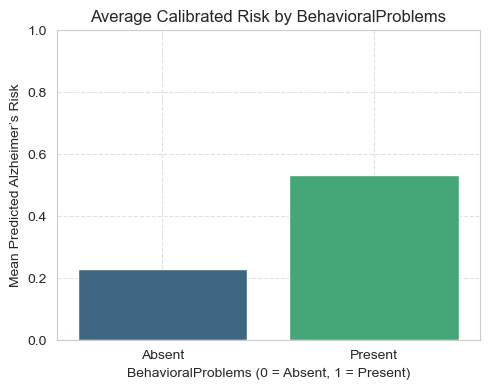

In [30]:
for feature in binary_features:
    plt.figure(figsize=(5, 4))
    sns.barplot(
        data=df_test,
        x=feature,
        y='alzheimers_risk',
        estimator='mean',
        errorbar=None,
        palette='viridis'
    )
    plt.title(f'Average Calibrated Risk by {feature}')
    plt.xlabel(f'{feature} (0 = Absent, 1 = Present)')
    plt.ylabel('Mean Predicted Alzheimer’s Risk')
    plt.ylim(0, 1)
    plt.xticks([0, 1], ['Absent', 'Present'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Continuous Features

In [32]:
# Define binned columns
binned_features = {
    'MMSE': 'MMSE_bin',
    'FunctionalAssessment': 'FA_bin',
    'ADL': 'ADL_bin',
    'SystolicBP': 'SystolicBP_bin'
}

# Create quantile-based bins
df_test['MMSE_bin'] = pd.qcut(df_test['MMSE'], q=3, labels=['Low', 'Medium', 'High'])
df_test['FA_bin'] = pd.qcut(df_test['FunctionalAssessment'], q=3, labels=['Low', 'Medium', 'High'])
df_test['ADL_bin'] = pd.qcut(df_test['ADL'], q=3, labels=['Low', 'Medium', 'High'])
df_test['SystolicBP_bin'] = pd.qcut(df_test['SystolicBP'], q=3, labels=['Low', 'Medium', 'High'])

# Loop through features and show both empirical and model-based risk
for feature, bin_col in binned_features.items():
    print(f"\n📊 {feature} — Empirical vs Calibrated Risk")
    
    # Empirical: observed diagnosis proportion (Diagnosis = 1)
    empirical = pd.crosstab(df_test[bin_col], df_test['Diagnosis'], normalize='index')[1].rename('Empirical')
    
    # Model-based: mean predicted risk
    model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')

    comparison = pd.concat([empirical, model], axis=1).round(3)
    display(comparison)


📊 MMSE — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_34425/1488104045.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
MMSE_bin,,
Low,0.352,0.331
Medium,0.341,0.344
High,0.154,0.142



📊 FunctionalAssessment — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_34425/1488104045.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
FA_bin,,
Low,0.527,0.524
Medium,0.242,0.224
High,0.077,0.070



📊 ADL — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_34425/1488104045.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
ADL_bin,,
Low,0.451,0.453
Medium,0.286,0.273
High,0.110,0.091



📊 SystolicBP — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_34425/1488104045.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
SystolicBP_bin,,
Low,0.261,0.259
Medium,0.256,0.243
High,0.330,0.315


**Interpretation for the effect of MMSE (Mini-Mental State Examination) on Alzheimer's risk:**

- Patients in the High MMSE group (i.e., higher cognitive function) have the lowest Alzheimer’s risk both empirically and by the model — as expected.
- The model is extremely well-calibrated here. It not only matches the pattern, but also the exact risk levels almost perfectly.
 
**Interpretation for the effect of Functional Assessment on Alzheimer's risk:**

- Strong, clear decreasing trend — lower FA (i.e., more impairment) → higher Alzheimer’s risk.
- Here too, the model is extremely well-calibrated. 
- Suggests FA is a robust and reliable predictor in our model and in real-world patient data.

**Interpretation for the effect of ADL (Activities of Daily Living) on Alzheimer's risk:**

- Again, a clear inverse relationship — more difficulty with daily tasks (lower ADL score) → higher risk of Alzheimer’s.
- Model risk aligns nearly identically with empirical risk.
- Confirms that functional independence is a strong marker of cognitive decline in this population.

**Interpretation for the effect of SystolicBP on Alzheimer's risk:**

- Unlike MMSE, FA, or ADL, this doesn’t show a strong monotonic trend.
- High SystolicBP levels are associated with the highest Alzheimer’s risk, both empirically and in model predictions, but the risk doesn't vary significantly from the other two groups (Low SystolicBP and Medium SystolicBP).
- The model captures the general shape of the trend, though with slightly less separation between bins than in the empirical data.

This is not surprising, as SystolicBP was the least important feature among the features we considered for patients witth no memory complaints.

In [35]:
# Check if the bins are balanced

for col in ['MMSE_bin', 'FA_bin', 'ADL_bin', 'SystolicBP_bin']:
    print(f"\n{col} value counts:")
    print(df_test[col].value_counts(dropna=False))


MMSE_bin value counts:
MMSE_bin
Low       91
Medium    91
High      91
Name: count, dtype: int64

FA_bin value counts:
FA_bin
Low       91
Medium    91
High      91
Name: count, dtype: int64

ADL_bin value counts:
ADL_bin
Low       91
Medium    91
High      91
Name: count, dtype: int64

SystolicBP_bin value counts:
SystolicBP_bin
Low       92
High      91
Medium    90
Name: count, dtype: int64


## Compare averages of features across risk groups

In [49]:
df_test.groupby('risk_group')[['MMSE', 'FunctionalAssessment', 'ADL']].mean().round(2)

,MMSE,FunctionalAssessment,ADL
risk_group,,,
High,10.70,2.77,3.27
Low,15.32,5.62,5.66
Medium,16.35,4.96,1.58


In [51]:
df_test.groupby('risk_group')[['BehavioralProblems']].mean().round(2)

,BehavioralProblems
risk_group,
High,0.32
Low,0.08
Medium,0.00


## Hidden High-Risk Patients

In [53]:
# Find patients who were not diagnosed with Alzheimer’s, but have high predicted risk
high_risk_undiagnosed = df_test[(df_test['Diagnosis'] == 0) & (df_test['alzheimers_risk'] > 0.66)]
high_risk_undiagnosed.shape

(4, 39)

In [55]:
df_test.shape

(273, 39)

**Note:** 4 individuals out of 273 in the test set have not been diagnosed with Alzheimer’s (Diagnosis = 0), but have high model-predicted risk (alzheimers_risk > 0.66).

That’s only about 1.46% of our test set.